In [9]:
import numpy as np
import pandas as pd

import geopandas as gpd

from pyproj import Transformer

from scipy.linalg import block_diag

import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

import seaborn as sns

from kalman import KalmanFilter

# Functions

In [70]:
def interpolate_voyage_vars(voyage_data: pd.DataFrame, quay_point):

    interpolated_data = voyage_data[["x", "y"]].interpolate(method="linear", axis=0)

    # convert position
    transformer_meterstodeg = Transformer.from_crs(crs_from=3857, crs_to=4326)
    lat, lon = transformer_meterstodeg.transform(interpolated_data["x"].to_numpy(),
                                                 interpolated_data["y"].to_numpy())
    interpolated_data["LON"] = lon
    interpolated_data["LAT"] = lat

    interpolated_data_shift1 = interpolated_data.shift(1)
    interpolated_data = interpolated_data.assign(SOG=voyage_data["SOG"],
                                                 COG=voyage_data["COG"],
                                                 distanceToPort=voyage_data["distanceToPort"])

    # fill speed over ground (euclidean_distance/sampling interval)
    sog = np.sqrt((interpolated_data["x"] - interpolated_data_shift1["x"])**2
                  + (interpolated_data["y"] - interpolated_data_shift1["y"])**2) / 120 \
          / 0.5144444 # m/s to knots
    interpolated_data["SOG"].fillna(sog, inplace=True)

    # fill course over ground (angle in relation to the true North)
    cog = np.arctan2(interpolated_data["x"] - interpolated_data_shift1["x"],
                     interpolated_data["y"] - interpolated_data_shift1["y"]) % (2 * np.pi) \
          * 180 / np.pi # from radians to degrees
    interpolated_data["COG"].fillna(cog, inplace=True)
    
    # fill distance to port
    dist = np.sqrt((interpolated_data["x"] - quay_point[0])**2
                   + (interpolated_data["y"] - quay_point[1])**2) \
           * 0.000539956803 # meters to nautical miles
    interpolated_data["distanceToPort"].fillna(dist, inplace=True)

    # remove positions in meters
    interpolated_data.drop(columns=["x", "y"], inplace=True)

    return interpolated_data

In [71]:
def cv_model_2d(dt, accel, meas_noise):

    F = np.eye(4)
    F[0, 1] = F[2, 3] = dt
    H = np.zeros((2,4))
    H[0,0] = H[1,2] = 1

    block = np.array([[dt**4/4, dt**3/2],
                      [dt**3/2, dt**2]])
    Q = block_diag(block, block) * (accel**2)

    R = np.eye(2) * (meas_noise ** 2)
    P = np.eye(4) * 0.01

    return F, H, Q, R, P

def extrapolate_voyage_vars(voyage_data, quay_point):

    # Get KF measures and AIS messages in different arrays
    kf_measures = voyage_data[["x", "vx", "y", "vy"]].values
    voyage_vars = voyage_data[["LON", "LAT", "SOG", "COG", "distanceToPort"]].values

    # Initialize Kalman Filter
    F, H, Q, R, P = cv_model_2d(120, 0.001, 10)
    x0 = kf_measures[0, :, np.newaxis]
    kf = KalmanFilter(x0, F, None, H, Q, R, P)

    # Save P for reset
    P = kf.P

    # Variables
    reset = False
    extrapolated_voyage_vars = np.zeros(shape=(voyage_data.shape[0], 5)) # array of predictions

    # filter the voyage data
    for i in range(1, kf_measures.shape[0]):

        if reset and np.isnan(kf_measures[i,0]): # if there is no info
            continue
        elif reset: # if there is info and KF needs reset
            kf.x = kf_measures[i, :, np.newaxis]
            kf.P = P

        kf.predict()

        # current measure available for correction
        if ~np.isnan(kf_measures[i, 0]):
            kf.update(kf_measures[i, [0, 2], np.newaxis])
            continue

        #past_x, past_y = kf_measures[i-1, [0, 2]]
        x, y = kf.x[0, 0], kf.x[2, 0]
        vel = np.sqrt((kf.x[0, 0] - kf_measures[i-1, 0]) ** 2 + (kf.x[2, 0] - kf_measures[i-1, 2]) ** 2) / 120
        cog = np.arctan2(kf.x[0, 0] - kf_measures[i-1, 0], kf.x[2, 0] - kf_measures[i-1, 2]) % (2 * np.pi)
        dist = np.sqrt((kf.x[0, 0] - quay_point[0]) ** 2 + (kf.x[2, 0] - quay_point[1]) ** 2)
        extrapolated_voyage_vars[i, :] = np.array([x, y, vel, cog, dist])
        reset = True

    extrapolated_voyage_vars[np.isnan(extrapolated_voyage_vars[:,0])] = np.NaN

    transformer = Transformer.from_crs(3857, 4326)
    lat, lon = transformer.transform(extrapolated_voyage_vars[:, 0], extrapolated_voyage_vars[:, 1])
    extrapolated_voyage_vars[:, 0] = lon
    extrapolated_voyage_vars[:, 1] = lat
    extrapolated_voyage_vars[:, 2] /= 0.5144444
    extrapolated_voyage_vars[:, 3] *= 180 / np.pi
    extrapolated_voyage_vars[:, 4] *= 0.000539956803

    # add existing AIS messages to extrapolated voyage
    extrapolated_voyage_vars[~np.isnan(voyage_vars[:,0])] = voyage_vars[~np.isnan(voyage_vars[:,0])]

    # add variables to voyage data
    extrapolated_voyage_vars = pd.DataFrame(data=extrapolated_voyage_vars,
                                            columns=["LON", "LAT", "SOG", "COG", "distanceToPort"])

    return extrapolated_voyage_vars

In [72]:
def get_lagged_voyage_vars(voyage_vars, delays):

    voyage_vars_lagged = voyage_vars.copy()

    for delay in delays:
        voyage_vars_lag = voyage_vars.shift(delay)

        voyage_vars_lag.columns += "_lag" + str(delay)
        voyage_vars_lagged = pd.concat((voyage_vars_lagged, voyage_vars_lag), axis=1)

    return voyage_vars_lagged

In [108]:
def complete_vars(arr, n_feats, total_cols):

    voyage_lags = arr[:total_cols]
    voyage_interp_lags = arr[total_cols:total_cols*2]
    voyage_extrap_lags = arr[total_cols*2:total_cols*3]

    non_nan_indexes = np.argwhere(~np.isnan(voyage_lags))
    if non_nan_indexes.shape[0] == 0 or non_nan_indexes[0, 0] == 0:
        return voyage_lags

    interp_end = non_nan_indexes[0, 0]
    voyage_lags[interp_end:] = voyage_interp_lags[interp_end:]
    voyage_lags[interp_end-n_feats:interp_end] = \
        voyage_extrap_lags[interp_end-n_feats:interp_end]

    return voyage_lags

def get_stacked_voyage_vars_lagged(voyage_vars, delays, extrapolate, quay_point):

    voyage_vars_lagged = get_lagged_voyage_vars(voyage_vars[["LON", "LAT", "SOG", "COG", "distanceToPort"]],
                                                delays=delays)
    voyage_interp = interpolate_voyage_vars(voyage_vars, quay_point)
    voyage_interp_lagged = get_lagged_voyage_vars(voyage_interp, delays=delays)

    if extrapolate:
        voyage_extrap = extrapolate_voyage_vars(voyage_vars, quay_point)
        voyage_extrap_lagged = get_lagged_voyage_vars(voyage_extrap, delays=delays)

        voyage_vars_lagged_stacked = np.hstack((voyage_vars_lagged.values,
                                                voyage_interp_lagged.values,
                                                voyage_extrap_lagged.values))
    else:
        voyage_with_outdated_samples = voyage_vars.loc[:, ["LON", "LAT", "SOG", "COG", "distanceToPort"]].ffill(limit=1)
        voyage_with_outdated_samples_lagged = get_lagged_voyage_vars(voyage_with_outdated_samples, delays=delays)
        voyage_vars_lagged_stacked = np.hstack((voyage_vars_lagged.values,
                                                voyage_interp_lagged.values,
                                                voyage_with_outdated_samples_lagged.values))

    return voyage_vars_lagged_stacked

In [94]:
def get_lagged_cols(columns: np.array, delays):
    columns = np.array(columns)
    final_columns = columns.copy()
    for delay in delays:
        final_columns = np.hstack((final_columns, np.char.add(columns, "_lag" + str(delay))))
    return final_columns

def get_lagged_vars(data: pd.DataFrame, delays, online, fill, extrapolate, quay_point):

    if not fill:
        return data.groupby(level=0, sort=False, group_keys=False)\
            .apply(lambda x: get_lagged_voyage_vars(x, delays))

    if not online:
        return data.groupby(level=0, sort=False, group_keys=False)\
            .apply(lambda x: get_lagged_voyage_vars(interpolate_voyage_vars(x, quay_point), delays))

    stacked_voyage_vars_lagged =  data.groupby(level=0, sort=False, group_keys=False)\
        .apply(lambda x: get_stacked_voyage_vars_lagged(x, delays, extrapolate, quay_point))
    
    stacked_voyage_vars_lagged = np.vstack(stacked_voyage_vars_lagged.values)

    n_feats = int(stacked_voyage_vars_lagged.shape[1] / 3 / (delays[-1]+1))
    voyage_vars_lagged_filled = np.apply_along_axis(lambda x: complete_vars(x,
                                                                            n_feats,
                                                                            n_feats * (delays[-1]+1)),
                                                    axis=1,
                                                    arr=stacked_voyage_vars_lagged)

    voyage_vars_lagged_filled = pd.DataFrame(data=voyage_vars_lagged_filled,
                                             columns=get_lagged_cols(["LON", "LAT",
                                                                      "SOG", "COG",
                                                                      "distanceToPort"], delays))

    return voyage_vars_lagged_filled

In [95]:
def get_lagged_io(lagged_vars: pd.DataFrame, target_var: pd.Series, n_feats, max_delay):

    target_var.interpolate(method="linear", inplace=True)
    lagged_io = pd.concat((lagged_vars.iloc[:, :n_feats*(max_delay+1)], target_var), axis=1)
    lagged_io.loc[lagged_io.iloc[:, :-1].isna().any(axis=1), target_var.name] = np.NaN

    return lagged_io

# Miami Data

### Training Data

In [8]:
# Train set -> Linear Interpolation
train = pd.read_csv("../data/3_miami_train_to_fill.csv")
train["BaseDateTime"] = pd.to_datetime(train["BaseDateTime"])
train.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)

In [9]:
display(train.head())

vessel  voyage       LON       LAT   SOG   COG  \
voyage_id BaseDateTime                                                          
3-0       2018-03-22 00:01:33       3       0 -83.81050  23.03358  19.8  53.8   
          2018-03-22 00:02:52       3       0 -83.80440  23.03782  19.7  52.7   
          2018-03-22 00:03:58       3       0 -83.79900  23.04156  19.7  53.1   
          2018-03-22 00:07:03       3       0 -83.78424  23.05172  19.9  52.9   
          2018-03-22 00:08:39       3       0 -83.77661  23.05693  19.8  53.8   

                               distanceToPort  remainingVoyageTime  \
voyage_id BaseDateTime                                               
3-0       2018-03-22 00:01:33      284.212507          2218.766667   
          2018-03-22 00:02:52      283.753418          2217.450000   
          2018-03-22 00:03:58      283.347566          2216.350000   
          2018-03-22 00:07:03      282.240824          2213.266667   
          2018-03-22 00:08:39      281.670447          2211.666667   

                                          x             y  
voyage_id BaseDateTime                                     
3-0       2018-03-22 00:01:33 -9.329742e+06  2.636080e+06  
          2018-03-22 00:02:52 -9.329063e+06  2.636593e+06  
          2018-03-22 00:03:58 -9.328462e+06  2.637045e+06  
          2018-03-22 00:07:03 -9.326819e+06  2.638274e+06  
          2018-03-22 00:08:39 -9.325970e+06  2.638905e+06

In [10]:
# Resample to 2 minutes intervals by taking the meane very 2 minutes
train_resampled = train.groupby(level=0, sort=False)\
            .resample("2T", level=1).mean()

In [11]:
display(train_resampled.head())

vessel  voyage        LON        LAT    SOG  \
voyage_id BaseDateTime                                                       
3-0       2018-03-22 00:00:00     3.0     0.0 -83.810500  23.033580  19.80   
          2018-03-22 00:02:00     3.0     0.0 -83.801700  23.039690  19.70   
          2018-03-22 00:04:00     NaN     NaN        NaN        NaN    NaN   
          2018-03-22 00:06:00     3.0     0.0 -83.784240  23.051720  19.90   
          2018-03-22 00:08:00     3.0     0.0 -83.773435  23.059095  19.85   

                                COG  distanceToPort  remainingVoyageTime  \
voyage_id BaseDateTime                                                     
3-0       2018-03-22 00:00:00  53.8      284.212507          2218.766667   
          2018-03-22 00:02:00  52.9      283.550492          2216.900000   
          2018-03-22 00:04:00   NaN             NaN                  NaN   
          2018-03-22 00:06:00  52.9      282.240824          2213.266667   
          2018-03-22 00:08:00  53.5      281.433224          2211.008333   

                                          x             y  
voyage_id BaseDateTime                                     
3-0       2018-03-22 00:00:00 -9.329742e+06  2.636080e+06  
          2018-03-22 00:02:00 -9.328763e+06  2.636819e+06  
          2018-03-22 00:04:00           NaN           NaN  
          2018-03-22 00:06:00 -9.326819e+06  2.638274e+06  
          2018-03-22 00:08:00 -9.325616e+06  2.639167e+06

In [76]:
transformer = Transformer.from_crs(4326, 3857)
quay_point = transformer.transform(25.77, -80.16)

In [77]:
delays = np.arange(1, 16)

In [14]:
train_vars_lagged = get_lagged_vars(train_resampled[["LON", "LAT",
                                                     "SOG", "COG",
                                                     "distanceToPort"]],
                                    delays=delays,
                                    online=False, fill=False, quay_point=None)
train_nohistory = get_lagged_io(train_vars_lagged,
                                train_resampled["remainingVoyageTime"],
                                n_feats=5, max_delay=0)
train_10min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=5)
train_20min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=10)
train_30min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=15)

In [15]:
train_vars_lagged_filled = get_lagged_vars(train_resampled[["LON", "LAT",
                                                            "SOG", "COG",
                                                            "distanceToPort",
                                                            "x", "y"]],
                                           delays=delays,
                                           online=False, fill=True, quay_point=quay_point)
train_filled_nohistory = get_lagged_io(train_vars_lagged_filled,
                                       train_resampled["remainingVoyageTime"],
                                       n_feats=5, max_delay=0)
train_filled_10min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=5)
train_filled_20min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=10)
train_filled_30min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=15)

In [16]:
train_nohistory.dropna()\
    .to_csv("../data/final_miami_datasets/no_history/train.csv", index=True)
train_10min.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history/train.csv", index=True)
train_20min.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history/train.csv", index=True)
train_30min.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history/train.csv", index=True)

In [17]:
train_filled_nohistory.dropna()\
    .to_csv("../data/final_miami_datasets/no_history_filled/train.csv", index=True)
train_filled_10min.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history_filled/train.csv", index=True)
train_filled_20min.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history_filled/train.csv", index=True)
train_filled_30min.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history_filled/train.csv", index=True)

### Validation and Test sets

In [96]:
val = pd.read_csv("../data/3_miami_val_to_fill.csv")
test = pd.read_csv("../data/3_miami_test_to_fill.csv")

val["BaseDateTime"] = pd.to_datetime(val["BaseDateTime"])
test["BaseDateTime"] = pd.to_datetime(test["BaseDateTime"])
val.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)
test.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)

val_vx = val["SOG"] * 0.5144444 * np.sin(val["COG"])
val_vy = val["SOG"] * 0.5144444 * np.cos(val["COG"])
val = val.assign(vx=val_vx, vy=val_vy)

test_vx = test["SOG"] * 0.5144444 * np.sin(test["COG"])
test_vy = test["SOG"] * 0.5144444 * np.cos(test["COG"])
test = test.assign(vx=test_vx, vy=test_vy)

In [97]:
display(val.head()[:2])
display(test.head()[:2])

vessel  voyage       LON       LAT  SOG    COG  \
voyage_id BaseDateTime                                                          
3-5       2020-04-30 02:42:38       3       5 -81.13225  32.11904  0.1  194.5   
          2020-04-30 02:43:49       3       5 -81.13225  32.11906  0.0  194.5   

                               distanceToPort  remainingVoyageTime  \
voyage_id BaseDateTime                                               
3-5       2020-04-30 02:42:38      440.355269          2219.800000   
          2020-04-30 02:43:49      440.356676          2218.616667   

                                          x             y        vx        vy  
voyage_id BaseDateTime                                                         
3-5       2020-04-30 02:42:38 -9.031601e+06  3.778947e+06 -0.014155  0.049459  
          2020-04-30 02:43:49 -9.031601e+06  3.778949e+06 -0.000000  0.000000

vessel  voyage       LON       LAT  SOG    COG  \
voyage_id BaseDateTime                                                          
3-8       2020-07-02 00:00:12       3       8 -81.12861  32.11636  6.4  137.9   
          2020-07-02 00:01:21       3       8 -81.12683  32.11463  7.0  139.5   

                               distanceToPort  remainingVoyageTime  \
voyage_id BaseDateTime                                               
3-8       2020-07-02 00:00:12      440.137760              2133.40   
          2020-07-02 00:01:21      440.001922              2132.25   

                                          x             y        vx        vy  
voyage_id BaseDateTime                                                         
3-8       2020-07-02 00:00:12 -9.031196e+06  3.778594e+06 -1.067133  3.114710  
          2020-07-02 00:01:21 -9.030997e+06  3.778367e+06  3.439342  1.067204

In [98]:
# Resample to 2 minutes intervals by taking the mean every 2 minutes
val_resampled = val.groupby(level=0, sort=False) \
    .resample("2T", level=1).mean()
test_resampled = test.groupby(level=0, sort=False) \
    .resample("2T", level=1).mean()

In [99]:
print(val_resampled.isna().sum()[0] / val_resampled.shape[0] * 100)
print(test_resampled.isna().sum()[0] / test_resampled.shape[0] * 100)

22.693231971561897
27.212046374425462


/var/folders/g6/hyzqbnw94ns3yxmxnj3v8hkw0000gn/T/ipykernel_3887/2971071605.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_resampled.isna().sum()[0] / val_resampled.shape[0] * 100)
/var/folders/g6/hyzqbnw94ns3yxmxnj3v8hkw0000gn/T/ipykernel_3887/2971071605.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(test_resampled.isna().sum()[0] / test_resampled.shape[0] * 100)


In [100]:
val_vars_lagged = get_lagged_vars(val_resampled[["LON", "LAT",
                                                 "SOG", "COG",
                                                 "distanceToPort"]],
                                  delays=delays,
                                  online=True, fill=False, extrapolate=False, quay_point=None)
val_nohistory = get_lagged_io(val_vars_lagged,
                              val_resampled["remainingVoyageTime"],
                              n_feats=5, max_delay=0)
val_10min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=5)
val_20min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=10)
val_30min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=15)

In [111]:
val_vars_lagged = get_lagged_vars(val_resampled[["LON", "LAT", "SOG", "COG", "distanceToPort", "x", "y", "vx", "vy"]],
                                  delays=delays, online=True, fill=True,  extrapolate=False, quay_point=quay_point)
val_vars_lagged.index = val_resampled.index
val_nohistory_with_outdated_samples = get_lagged_io(val_vars_lagged,
                              val_resampled["remainingVoyageTime"],
                              n_feats=5, max_delay=0)
val_10min_with_outdated_samples = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=5)
val_20min_with_outdated_samples = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=10)
val_30min_with_outdated_samples = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=15)

In [32]:
test_vars_lagged = get_lagged_vars(test_resampled[["LON", "LAT",
                                                   "SOG", "COG",
                                                   "distanceToPort"]],
                                   delays=delays,
                                   online=True, fill=False, quay_point=None)
test_nohistory = get_lagged_io(test_vars_lagged,
                               test_resampled["remainingVoyageTime"],
                               n_feats=5, max_delay=0)
test_10min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=5)
test_20min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=10)
test_30min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=15)

In [19]:
val_vars_lagged_filled = get_lagged_vars(val_resampled[["LON", "LAT",
                                                        "SOG", "COG",
                                                        "distanceToPort", "x", "y", "vx", "vy"]],
                                         delays=delays,
                                         online=True, fill=True, quay_point=quay_point)
val_vars_lagged_filled.index = val_resampled.index
val_nohistory_filled = get_lagged_io(val_vars_lagged_filled,
                                     val_resampled["remainingVoyageTime"],
                                     n_feats=5, max_delay=0)
val_10min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=5)
val_20min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=10)
val_30min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=15)

In [24]:
test_vars_lagged_filled = get_lagged_vars(test_resampled[["LON", "LAT",
                                                          "SOG", "COG",
                                                          "distanceToPort", "x", "y", "vx", "vy"]],
                                          delays=delays,
                                          online=True, fill=True, quay_point=quay_point)
test_vars_lagged_filled.index = test_resampled.index
test_nohistory_filled = get_lagged_io(test_vars_lagged_filled,
                                      test_resampled["remainingVoyageTime"],
                                      n_feats=5, max_delay=0)
test_10min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=5)
test_20min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=10)
test_30min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=15)

In [25]:
val_nohistory.dropna()\
    .to_csv("../data/final_miami_datasets/no_history/val.csv", index=False)
val_10min.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history/val.csv", index=False)
val_20min.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history/val.csv", index=False)
val_30min.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history/val.csv", index=False)

In [115]:
val_nohistory_with_outdated_samples.dropna().to_csv("../data/final_miami_datasets/no_history/val_with_outdated_samples.csv", index=False)
val_10min_with_outdated_samples.dropna().to_csv("../data/final_miami_datasets/10min_history/val_with_outdated_samples.csv", index=False)
val_20min_with_outdated_samples.dropna().to_csv("../data/final_miami_datasets/20min_history/val_with_outdated_samples.csv", index=False)
val_30min_with_outdated_samples.dropna().to_csv("../data/final_miami_datasets/30min_history/val_with_outdated_samples.csv", index=False)

In [26]:
val_nohistory_filled.dropna()\
    .to_csv("../data/final_miami_datasets/no_history_filled/val.csv", index=False)
val_10min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history_filled/val.csv", index=False)
val_20min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history_filled/val.csv", index=False)
val_30min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history_filled/val.csv", index=False)

In [ ]:
test_nohistory.dropna()\
    .to_csv("../data/final_miami_datasets/no_history/test.csv", index=False)
test_10min.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history/test.csv", index=False)
test_20min.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history/test.csv", index=False)
test_30min.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history/test.csv", index=False)

In [ ]:
test_nohistory_filled.dropna()\
    .to_csv("../data/final_miami_datasets/no_history_filled/test.csv", index=False)
test_10min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/10min_history_filled/test.csv", index=False)
test_20min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/20min_history_filled/test.csv", index=False)
test_30min_filled.dropna()\
    .to_csv("../data/final_miami_datasets/30min_history_filled/test.csv", index=False)

# France Data

### Train Data

In [18]:
# Train set -> Linear Interpolation
train = pd.read_csv("../data/3_france_train_to_fill.csv")
train["BaseDateTime"] = pd.to_datetime(train["BaseDateTime"])
train.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)

In [19]:
# Resample to 2 minutes intervals by taking the meane very 2 minutes
train_resampled = train.groupby(level=0, sort=False)\
            .resample("2T", level=1).mean()

In [20]:
transformer = Transformer.from_crs(4326, 3857)

ports = gpd.read_file("../data/france_data/[C1] Ports of Brittany/port.shp")
brest_port = ports[ports["libelle_po"] == "Brest"]
lon = brest_port.iloc[0]["geometry"].geoms[0].xy[0][0]
lat = brest_port.iloc[0]["geometry"].geoms[0].xy[1][0]
berth_port_coords = [lat, lon-0.01]

quay_point = transformer.transform(lat, lon-0.01)

In [21]:
delays = np.arange(1, 16)

In [22]:
train_vars_lagged = get_lagged_vars(train_resampled[["LON", "LAT",
                                                     "SOG", "COG",
                                                     "distanceToPort"]],
                                    delays=delays,
                                    online=False, fill=False, quay_point=None)
train_nohistory = get_lagged_io(train_vars_lagged,
                                train_resampled["remainingVoyageTime"],
                                n_feats=5, max_delay=0)
train_10min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=5)
train_20min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=10)
train_30min = get_lagged_io(train_vars_lagged,
                            train_resampled["remainingVoyageTime"],
                            n_feats=5, max_delay=15)

In [23]:
train_vars_lagged_filled = get_lagged_vars(train_resampled[["LON", "LAT",
                                                            "SOG", "COG",
                                                            "distanceToPort",
                                                            "x", "y"]],
                                           delays=delays,
                                           online=False, fill=True, quay_point=quay_point)
train_filled_nohistory = get_lagged_io(train_vars_lagged_filled,
                                       train_resampled["remainingVoyageTime"],
                                       n_feats=5, max_delay=0)
train_filled_10min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=5)
train_filled_20min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=10)
train_filled_30min = get_lagged_io(train_vars_lagged_filled,
                                   train_resampled["remainingVoyageTime"],
                                   n_feats=5, max_delay=15)

In [24]:
train_nohistory.dropna()\
    .to_csv("../data/final_france_datasets/no_history/train.csv", index=True)
train_10min.dropna()\
    .to_csv("../data/final_france_datasets/10min_history/train.csv", index=True)
train_20min.dropna()\
    .to_csv("../data/final_france_datasets/20min_history/train.csv", index=True)
train_30min.dropna()\
    .to_csv("../data/final_france_datasets/30min_history/train.csv", index=True)

In [25]:
train_filled_nohistory.dropna()\
    .to_csv("../data/final_france_datasets/no_history_filled/train.csv", index=True)
train_filled_10min.dropna()\
    .to_csv("../data/final_france_datasets/10min_history_filled/train.csv", index=True)
train_filled_20min.dropna()\
    .to_csv("../data/final_france_datasets/20min_history_filled/train.csv", index=True)
train_filled_30min.dropna()\
    .to_csv("../data/final_france_datasets/30min_history_filled/train.csv", index=True)

### Validation and Test Data

In [61]:
val = pd.read_csv("../data/3_france_val_to_fill.csv")
test = pd.read_csv("../data/3_france_test_to_fill.csv")

val["BaseDateTime"] = pd.to_datetime(val["BaseDateTime"])
test["BaseDateTime"] = pd.to_datetime(test["BaseDateTime"])
val.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)
test.set_index(["voyage_id", "BaseDateTime"], drop=True, inplace=True)

val_vx = val["SOG"] * 0.5144444 * np.sin(val["COG"])
val_vy = val["SOG"] * 0.5144444 * np.cos(val["COG"])
val = val.assign(vx=val_vx, vy=val_vy)

test_vx = test["SOG"] * 0.5144444 * np.sin(test["COG"])
test_vy = test["SOG"] * 0.5144444 * np.cos(test["COG"])
test = test.assign(vx=test_vx, vy=test_vy)

In [62]:
# Resample to 2 minutes intervals by taking the mean every 2 minutes
val_resampled = val.groupby(level=0, sort=False) \
    .resample("2T", level=1).mean()
test_resampled = test.groupby(level=0, sort=False) \
    .resample("2T", level=1).mean()

In [63]:
print(val_resampled.isna().sum()[0] / val_resampled.shape[0] * 100)
print(test_resampled.isna().sum()[0] / test_resampled.shape[0] * 100)

63.813995758860955
62.971089313371195


In [28]:
val_vars_lagged = get_lagged_vars(val_resampled[["LON", "LAT",
                                                 "SOG", "COG",
                                                 "distanceToPort"]],
                                  delays=delays,
                                  online=True, fill=False, quay_point=None)
val_nohistory = get_lagged_io(val_vars_lagged,
                              val_resampled["remainingVoyageTime"],
                              n_feats=5, max_delay=0)
val_10min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=5)
val_20min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=10)
val_30min = get_lagged_io(val_vars_lagged,
                          val_resampled["remainingVoyageTime"],
                          n_feats=5, max_delay=15)

In [29]:
test_vars_lagged = get_lagged_vars(test_resampled[["LON", "LAT",
                                                   "SOG", "COG",
                                                   "distanceToPort"]],
                                   delays=delays,
                                   online=True, fill=False, quay_point=None)
test_nohistory = get_lagged_io(test_vars_lagged,
                               test_resampled["remainingVoyageTime"],
                               n_feats=5, max_delay=0)
test_10min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=5)
test_20min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=10)
test_30min = get_lagged_io(test_vars_lagged,
                           test_resampled["remainingVoyageTime"],
                           n_feats=5, max_delay=15)

In [30]:
val_vars_lagged_filled = get_lagged_vars(val_resampled[["LON", "LAT",
                                                        "SOG", "COG",
                                                        "distanceToPort", "x", "y", "vx", "vy"]],
                                         delays=delays,
                                         online=True, fill=True, quay_point=quay_point)
val_vars_lagged_filled.index = val_resampled.index
val_nohistory_filled = get_lagged_io(val_vars_lagged_filled,
                                     val_resampled["remainingVoyageTime"],
                                     n_feats=5, max_delay=0)
val_10min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=5)
val_20min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=10)
val_30min_filled = get_lagged_io(val_vars_lagged_filled,
                                 val_resampled["remainingVoyageTime"],
                                 n_feats=5, max_delay=15)

In [31]:
test_vars_lagged_filled = get_lagged_vars(test_resampled[["LON", "LAT",
                                                          "SOG", "COG",
                                                          "distanceToPort", "x", "y", "vx", "vy"]],
                                          delays=delays,
                                          online=True, fill=True, quay_point=quay_point)
test_vars_lagged_filled.index = test_resampled.index
test_nohistory_filled = get_lagged_io(test_vars_lagged_filled,
                                      test_resampled["remainingVoyageTime"],
                                      n_feats=5, max_delay=0)
test_10min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=5)
test_20min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=10)
test_30min_filled = get_lagged_io(test_vars_lagged_filled,
                                  test_resampled["remainingVoyageTime"],
                                  n_feats=5, max_delay=15)

In [32]:
val_nohistory.dropna()\
    .to_csv("../data/final_france_datasets/no_history/val.csv", index=False)
val_10min.dropna()\
    .to_csv("../data/final_france_datasets/10min_history/val.csv", index=False)
val_20min.dropna()\
    .to_csv("../data/final_france_datasets/20min_history/val.csv", index=False)
val_30min.dropna()\
    .to_csv("../data/final_france_datasets/30min_history/val.csv", index=False)

In [33]:
val_nohistory_filled.dropna()\
    .to_csv("../data/final_france_datasets/no_history_filled/val.csv", index=False)
val_10min_filled.dropna()\
    .to_csv("../data/final_france_datasets/10min_history_filled/val.csv", index=False)
val_20min_filled.dropna()\
    .to_csv("../data/final_france_datasets/20min_history_filled/val.csv", index=False)
val_30min_filled.dropna()\
    .to_csv("../data/final_france_datasets/30min_history_filled/val.csv", index=False)

In [34]:
test_nohistory.dropna()\
    .to_csv("../data/final_france_datasets/no_history/test.csv", index=False)
test_10min.dropna()\
    .to_csv("../data/final_france_datasets/10min_history/test.csv", index=False)
test_20min.dropna()\
    .to_csv("../data/final_france_datasets/20min_history/test.csv", index=False)
test_30min.dropna()\
    .to_csv("../data/final_france_datasets/30min_history/test.csv", index=False)

In [35]:
test_nohistory_filled.dropna()\
    .to_csv("../data/final_france_datasets/no_history_filled/test.csv", index=False)
test_10min_filled.dropna()\
    .to_csv("../data/final_france_datasets/10min_history_filled/test.csv", index=False)
test_20min_filled.dropna()\
    .to_csv("../data/final_france_datasets/20min_history_filled/test.csv", index=False)
test_30min_filled.dropna()\
    .to_csv("../data/final_france_datasets/30min_history_filled/test.csv", index=False)

# Plots and Tables of Availability

In [6]:
train_miami_nohist = pd.read_csv("../data/final_miami_datasets/no_history/train.csv")
val_miami_nohist = pd.read_csv("../data/final_miami_datasets/no_history/val.csv")
test_miami_nohist = pd.read_csv("../data/final_miami_datasets/no_history/test.csv")

train_miami_nohist_filled = pd.read_csv("../data/final_miami_datasets/no_history_filled/train.csv")
val_miami_nohist_filled = pd.read_csv("../data/final_miami_datasets/no_history_filled/val.csv")
test_miami_nohist_filled = pd.read_csv("../data/final_miami_datasets/no_history_filled/test.csv")

train_france_nohist = pd.read_csv("../data/final_france_datasets/no_history/train.csv")
val_france_nohist = pd.read_csv("../data/final_france_datasets/no_history/val.csv")
test_france_nohist = pd.read_csv("../data/final_france_datasets/no_history/test.csv")

train_france_nohist_filled = pd.read_csv("../data/final_france_datasets/no_history_filled/train.csv")
val_france_nohist_filled = pd.read_csv("../data/final_france_datasets/no_history_filled/val.csv")
test_france_nohist_filled = pd.read_csv("../data/final_france_datasets/no_history_filled/test.csv")

In [7]:
# Fazer bins de tempos restantes de viagem
bins = np.array([0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0]) * 60
labels= ["0-8", "8-16", "16-24", "24-32", "32-40", "40-48"]

train_miami_nohist_binned = pd.cut(x=train_miami_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_nohist_binned = pd.cut(x=val_miami_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
test_miami_nohist_binned = pd.cut(x=test_miami_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

train_miami_nohist_filled_binned = pd.cut(x=train_miami_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_nohist_filled_binned = pd.cut(x=val_miami_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
test_miami_nohist_filled_binned = pd.cut(x=test_miami_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

train_france_nohist_binned = pd.cut(x=train_france_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_nohist_binned = pd.cut(x=val_france_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
test_france_nohist_binned = pd.cut(x=test_france_nohist["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

train_france_nohist_filled_binned = pd.cut(x=train_france_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_nohist_filled_binned = pd.cut(x=val_france_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
test_france_nohist_filled_binned = pd.cut(x=test_france_nohist_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

In [8]:
train_miami_nohist_toplot = pd.concat((train_miami_nohist_binned, train_miami_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_miami_nohist_toplot = pd.concat((val_miami_nohist_binned, val_miami_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

test_miami_nohist_toplot = pd.concat((test_miami_nohist_binned, test_miami_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

train_france_nohist_toplot = pd.concat((train_france_nohist_binned, train_france_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_france_nohist_toplot = pd.concat((val_france_nohist_binned, val_france_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

test_france_nohist_toplot = pd.concat((test_france_nohist_binned, test_france_nohist_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

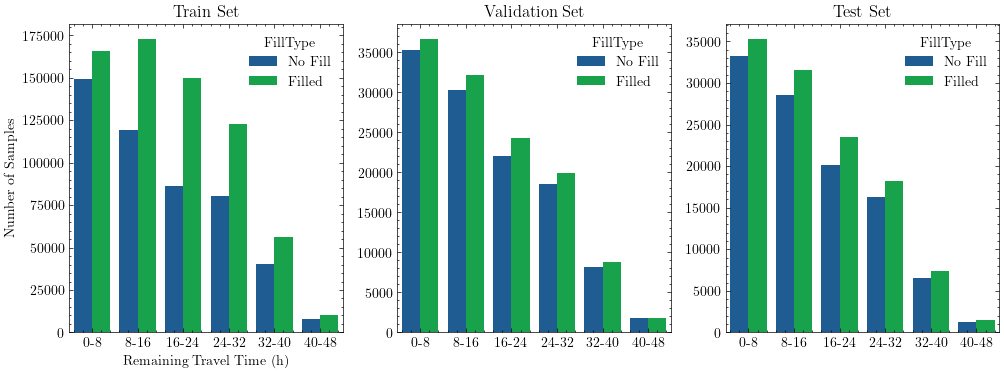

In [17]:
# Plots dos sets de treino val e teste sem historico para ambos os datasets
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.barplot(data=train_miami_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[0])
sns.barplot(data=val_miami_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[1])
sns.barplot(data=test_miami_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[2])

axs[0].set_title("Train Set")
axs[1].set_title("Validation Set")
axs[2].set_title("Test Set")

axs[0].set_ylabel("Number of Samples")
axs[0].set_xlabel("Remaining Travel Time (h)")

axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")


plt.savefig("../figures/tese/resultados/filling_missing_data/fill_miami_nohist_bar")
plt.show()

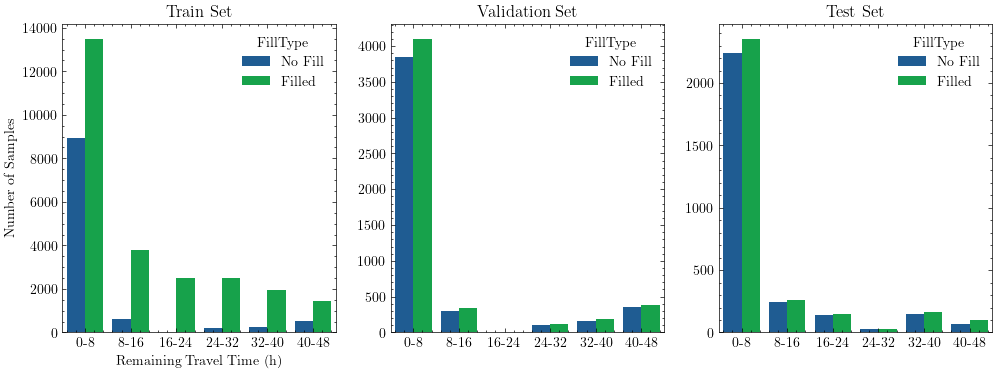

In [18]:
# Plots dos sets de treino val e teste sem historico para ambos os datasets
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.barplot(data=train_france_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[0])
sns.barplot(data=val_france_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[1])
sns.barplot(data=test_france_nohist_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[2])

axs[0].set_title("Train Set")
axs[1].set_title("Validation Set")
axs[2].set_title("Test Set")

axs[0].set_ylabel("Number of Samples")
axs[0].set_xlabel("Remaining Travel Time (h)")

axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")


plt.savefig("../figures/tese/resultados/filling_missing_data/fill_france_nohist_bar")
plt.show()

In [19]:
# Plots do set de val para os 3 historicos em ambos os datasets
val_miami_10min = pd.read_csv("../data/final_miami_datasets/10min_history/val.csv")
val_miami_20min = pd.read_csv("../data/final_miami_datasets/20min_history/val.csv")
val_miami_30min = pd.read_csv("../data/final_miami_datasets/30min_history/val.csv")

val_miami_10min_filled = pd.read_csv("../data/final_miami_datasets/10min_history_filled/val.csv")
val_miami_20min_filled = pd.read_csv("../data/final_miami_datasets/20min_history_filled/val.csv")
val_miami_30min_filled = pd.read_csv("../data/final_miami_datasets/30min_history_filled/val.csv")

val_france_10min = pd.read_csv("../data/final_france_datasets/10min_history/val.csv")
val_france_20min = pd.read_csv("../data/final_france_datasets/20min_history/val.csv")
val_france_30min = pd.read_csv("../data/final_france_datasets/30min_history/val.csv")

val_france_10min_filled = pd.read_csv("../data/final_france_datasets/10min_history_filled/val.csv")
val_france_20min_filled = pd.read_csv("../data/final_france_datasets/20min_history_filled/val.csv")
val_france_30min_filled = pd.read_csv("../data/final_france_datasets/30min_history_filled/val.csv")

In [20]:
# Fazer bins de tempos restantes de viagem
bins = np.array([0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0]) * 60
labels= ["0-8", "8-16", "16-24", "24-32", "32-40", "40-48"]

val_miami_10min_binned = pd.cut(x=val_miami_10min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_20min_binned = pd.cut(x=val_miami_20min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_30min_binned = pd.cut(x=val_miami_30min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

val_miami_10min_filled_binned = pd.cut(x=val_miami_10min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_20min_filled_binned = pd.cut(x=val_miami_20min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_miami_30min_filled_binned = pd.cut(x=val_miami_30min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

val_france_10min_binned = pd.cut(x=val_france_10min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_20min_binned = pd.cut(x=val_france_20min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_30min_binned = pd.cut(x=val_france_30min["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

val_france_10min_filled_binned = pd.cut(x=val_france_10min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_20min_filled_binned = pd.cut(x=val_france_20min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()
val_france_30min_filled_binned = pd.cut(x=val_france_30min_filled["remainingVoyageTime"], bins=bins, labels=labels)\
    .value_counts()

In [22]:
val_miami_10min_toplot = pd.concat((val_miami_10min_binned, val_miami_10min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_miami_20min_toplot = pd.concat((val_miami_20min_binned, val_miami_20min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_miami_30min_toplot = pd.concat((val_miami_30min_binned, val_miami_30min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_france_10min_toplot = pd.concat((val_france_10min_binned, val_france_10min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_france_20min_toplot = pd.concat((val_france_20min_binned, val_france_20min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

val_france_30min_toplot = pd.concat((val_france_30min_binned, val_france_30min_filled_binned),
                                    axis=1, keys=["No Fill", "Filled"])\
    .melt(var_name="FillType", value_name="Count", ignore_index=False)\
    .reset_index()

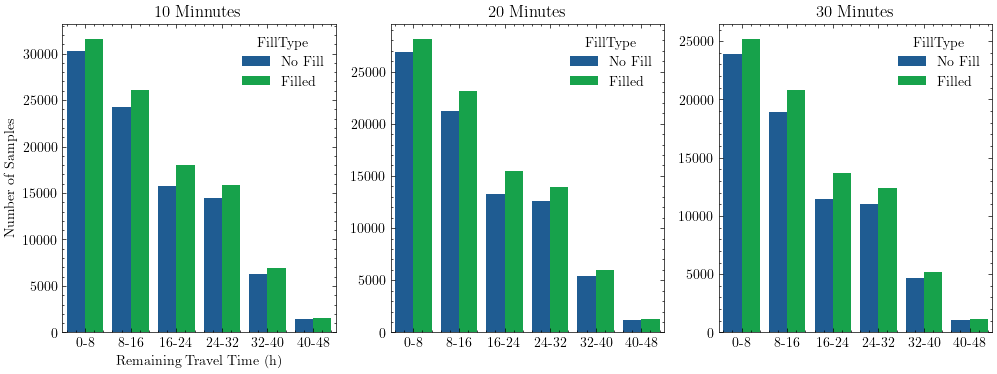

In [23]:
# Plots dos sets de treino val e teste sem historico para ambos os datasets
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.barplot(data=val_miami_10min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[0])
sns.barplot(data=val_miami_20min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[1])
sns.barplot(data=val_miami_30min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[2])

axs[0].set_title("10 Minnutes")
axs[1].set_title("20 Minutes")
axs[2].set_title("30 Minutes")

axs[0].set_ylabel("Number of Samples")
axs[0].set_xlabel("Remaining Travel Time (h)")

axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")


plt.savefig("../figures/tese/resultados/filling_missing_data/fill_miami_val_hist_bar")
plt.show()

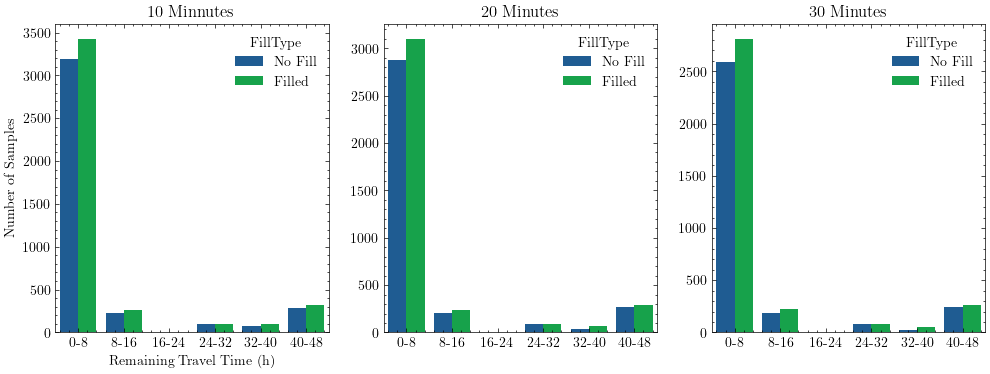

In [25]:
# Plots dos sets de treino val e teste sem historico para ambos os datasets
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.barplot(data=val_france_10min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[0])
sns.barplot(data=val_france_20min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[1])
sns.barplot(data=val_france_30min_toplot, x="remainingVoyageTime", y="Count", hue="FillType", ax=axs[2])

axs[0].set_title("10 Minnutes")
axs[1].set_title("20 Minutes")
axs[2].set_title("30 Minutes")

axs[0].set_ylabel("Number of Samples")
axs[0].set_xlabel("Remaining Travel Time (h)")

axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")


plt.savefig("../figures/tese/resultados/filling_missing_data/fill_france_val_hist_bar")
plt.show()